## Modelling Task

In [ ]:
from util import read_data_to_pandas, strip_date
from helper import create_lag_features, roll_forward_validation, plot_target_vs_pred, make_final_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

pd.options.mode.chained_assignment = None

In [2]:
DATA_PATH = 'http://www9.health.gov.au/cda/source/display_doc.cfm?DocID=1'

In [3]:
data_raw = read_data_to_pandas(DATA_PATH)
data_raw.head()

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,2018-01-05 00:00:00,NSW,00-04,Female,not available,B
1,2018-01-05 00:00:00,NSW,00-04,Female,not available,B
2,2018-01-05 00:00:00,NSW,00-04,Male,not available,A(unsubtyped)
3,2018-01-05 00:00:00,NSW,20-24,Male,not available,B
4,2018-01-05 00:00:00,NSW,25-29,Male,not available,A(unsubtyped)


**Sorting:** Since this is a time series data, It will be sorted by date in ascending order.

In [4]:
data = data_raw.copy()
data['Week Ending (Friday)'] = pd.to_datetime(data['Week Ending (Friday)'])
data.sort_values(by='Week Ending (Friday)', inplace=True)
data.head()

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
681253,2008-01-04,WA,80-84,Male,non-Indigenous,A(unsubtyped)
681239,2008-01-04,Qld,10-14,Female,non-Indigenous,A(H1N1)
681240,2008-01-04,Qld,30-34,Female,Unknown,A(unsubtyped)
681241,2008-01-04,Qld,55-59,Female,Unknown,A(unsubtyped)
681242,2008-01-04,Qld,65-69,Male,Unknown,A(unsubtyped)


**Feature Engineering 1:** Three features will be engineered from the date column, since this is the only variable in the data set that can be known in advance during forcasting.

In [5]:
#Grouping data by date and count the number cases for each date
Weekly_Flu_Count = data.groupby('Week Ending (Friday)').size()
Weekly_Count_data = pd.DataFrame()
Weekly_Count_data['Count'] = Weekly_Flu_Count
Weekly_Count_data.reset_index(inplace=True)

#Creating features from the dates
Weekly_Count_data['Week_in_Year'] = Weekly_Count_data['Week Ending (Friday)'].apply(lambda x:strip_date(str(x),'W'))
Weekly_Count_data['Month_in_Year'] = Weekly_Count_data['Week Ending (Friday)'].apply(lambda x:strip_date(str(x),'m'))
Weekly_Count_data['Year'] = Weekly_Count_data['Week Ending (Friday)'].apply(lambda x:strip_date(str(x),'y'))

In [6]:
# keep an original copy of the weekly count data frame
Weekly_Count_data1 = Weekly_Count_data.copy()
Weekly_Count_data1.head()

,Week Ending (Friday),Count,Week_in_Year,Month_in_Year,Year
0,2008-01-04,15,0,1,8
1,2008-01-11,23,1,1,8
2,2008-01-18,31,2,1,8
3,2008-01-25,26,3,1,8
4,2008-02-01,15,4,2,8


**Feature Engineering 2:** In this part features are created from the lag versions of the time series data.

In [7]:
Weekly_Count_data = create_lag_features(Weekly_Count_data, 'Count')
Weekly_Count_data.head()

,Count,Week_in_Year,Month_in_Year,Year,Last_1_Week_Flu_Counts,Last_1_Week_difference,Last_2_Week_Flu_Counts,Last_2_Week_difference
3,26,3,1,8,31.0,8.0,23.0,8.0
4,15,4,2,8,26.0,-5.0,31.0,8.0
5,30,5,2,8,15.0,-11.0,26.0,-5.0
6,33,6,2,8,30.0,15.0,15.0,-11.0
7,32,7,2,8,33.0,3.0,30.0,15.0


**Data Split: Train, Validation and Test Splits**
- Keeping `10%` of the overall data aside for final model testing
- Keeping `15%` of the remaining data for model validation and selection
- The remainder for Training ( rolling validation and test will be used)

In [8]:
# 10% test split
test_split_idx = int(0.9*len(Weekly_Count_data))
train_val_data = Weekly_Count_data.iloc[:test_split_idx,:] 
test_data = Weekly_Count_data.iloc[test_split_idx:,:]

# 15% of reaminder for validation
val_split_idx = round(0.85*len(train_val_data))

In [9]:
# some sanity check
assert((len(train_val_data) + len(test_data)) == len(Weekly_Count_data))

**Benchmarking**<br>
As a form of benchmarking, a model that uses the Flu count of last week as the predicted value for the current week will be built using the training set and evalated on the validation set. Going forward, this will serve as the baseline to which any sophisticated model built will be compared.

In [10]:
mean_error = []
pred_ = []
val_ = []
week_ = []
for week in range(val_split_idx, len(train_val_data)):
    week_.append(week)
    val = train_val_data.iloc[week, :]
    val_.append(val['Count'])
    
    pred = val['Last_1_Week_Flu_Counts']
    pred_.append(pred)
error = mean_absolute_error(val_, pred_)
print('Here is the baseline error rate that must be beaten: {}'.format(error))

Here is the baseline error rate that must be beaten: 371.45714285714286


Going forward, any model trained on this data set must achieve an MAE that is below **371**. Below is the plot of the target and predicted values using the validation data and the baseline model.

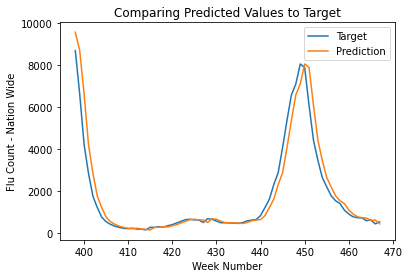

In [11]:
plot_target_vs_pred(val_, pred_, week_, ['Target', 'Prediction'])

### Roll Forward Training and Validation

**Random Forest Model** 

MAE Error: 235.83939999999998


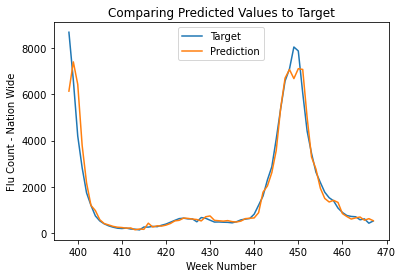

In [36]:
model_rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
target_val, pred_val, weeks = roll_forward_validation(model_rf, train_val_data, val_split_idx)
plot_target_vs_pred(target_val, pred_val, weeks, ['Target', 'Prediction'])

**Gradient Boost Model** 

MAE Error: 282.06553377953395


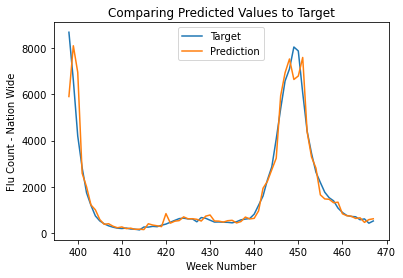

In [41]:
model_gb = GradientBoostingRegressor(n_estimators=1000, random_state=0)
target_val, pred_val, weeks = roll_forward_validation(model_gb, train_val_data, val_split_idx)
plot_target_vs_pred(target_val, pred_val, weeks, ['Target', 'Prediction'])

**XGBoost Model**

MAE Error: 222.584888785226


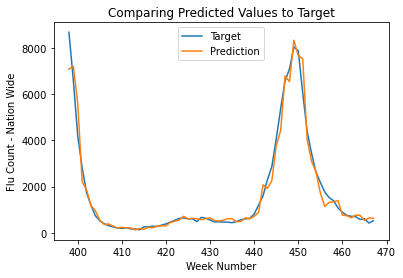

In [14]:
# XGBoost with default hyper-parameters
model_xg_default = XGBRegressor()
target_val, pred_val, weeks = roll_forward_validation(model_xg_default, train_val_data, val_split_idx)
plot_target_vs_pred(target_val, pred_val, weeks, ['Target', 'Prediction'])

**Quick Hyper Parameter Tunning - XGBoost**

In [15]:
X_data, Y_data = Weekly_Count_data.drop('Count', axis=1), Weekly_Count_data['Count']

In [16]:
param_test = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)}

gs1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)

gs1.fit(X_data, Y_data)
gs1.best_estimator_, gs1.best_params_, gs1.best_score_

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None),
 {'max_depth': 3, 'min_child_weight': 3},
 -941.9996304617744)

In [17]:
param_test = {'gamma':[i/10.0 for i in range(0,5)]}

gs2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)

gs2.fit(X_data, Y_data)
gs2.best_estimator_, gs2.best_params_, gs2.best_score_

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None),
 {'gamma': 0.0},
 -941.9996304617744)

In [18]:
param_test = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gs3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)

gs3.fit(X_data, Y_data)
gs3.best_estimator_, gs3.best_params_, gs3.best_score_

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None),
 {'colsample_bytree': 0.9, 'subsample': 0.7},
 -928.0673646679372)

In [19]:
param_test = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

gs4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.9,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test, scoring='neg_root_mean_squared_error',n_jobs=4, cv=5)

gs4.fit(X_data, Y_data)
gs4.best_estimator_, gs4.best_params_, gs4.best_score_

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None),
 {'reg_alpha': 1e-05},
 -928.0673781564849)

**Final Hyper-paramaters**

In [20]:
objective = 'reg:squarederror'
n_estimators = 1000 
learning_rate = 0.01 
max_depth = 5 
subsample = 0.8

### Evaluation Of Final Model

**Roll forward eveluation on the validation**

MAE Error: 182.03989933558873


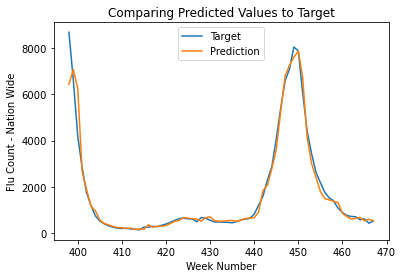

In [21]:
model_val = make_final_model()
target_val, pred_val, weeks = roll_forward_validation(model_val, train_val_data, val_split_idx)
plot_target_vs_pred(target_val, pred_val, weeks, ['Target', 'Prediction'])

**Feature Importance**

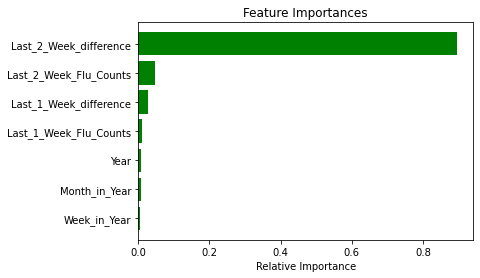

In [22]:
features = list(Weekly_Count_data.drop('Count', axis=1).columns)
importances = model_val.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')
plt.show()

**Evaluation on held out test set - using conventional method**

MAE Error: 2183.830547626202


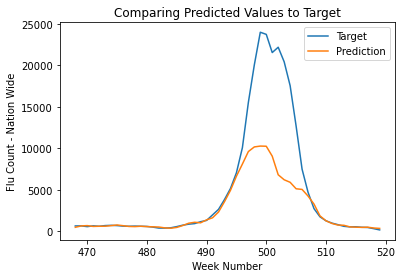

In [43]:
data_df = Weekly_Count_data
mean_error = []
predicted_test = []
target_test = []
weeks = []
target_var = list(data_df.columns)[0]
for week in range(test_split_idx, len(data_df)):
    weeks.append(week)
    #train = data_df.iloc[:week, :]
    test = data_df.iloc[[week]]
    target_test.append(test[target_var])
    X_test = test.drop(target_var, axis=1)
    y_test = test[target_var].values
    pred = model_val.predict(X_test) 
    predicted_test.append(pred)
error = mean_absolute_error(predicted_test, target_test)
print('MAE Error: {}'.format(error))
plot_target_vs_pred(target_test, predicted_test, weeks, ['Target', 'Prediction'])

**Evaluation on held out test set - using Roll Forward Method**

MAE Error: 835.3317560049204


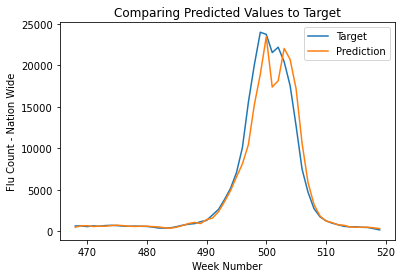

In [24]:
model = make_final_model()
target_test, pred_test, weeks = roll_forward_validation(model, Weekly_Count_data, test_split_idx)
plot_target_vs_pred(target_test, pred_test, weeks, ['Target', 'Prediction'])

### Next Six Month Nation Wide Flu Case Forcasting

**Creating weekly features for the next `6` months: `2018-01-12` to `2018-07-02`**

In [25]:
future_data = pd.DataFrame()
future_data['Week Ending (Friday)'] = pd.date_range(start='2018-01-12', end='2018-07-02', freq='W-FRI').values
future_data['Count'] = np.nan

#Creating features from the dates
future_data['Week_in_Year'] = future_data['Week Ending (Friday)'].apply(lambda x:strip_date(str(x),'W'))
future_data['Month_in_Year'] = future_data['Week Ending (Friday)'].apply(lambda x:strip_date(str(x),'m'))
future_data['Year'] = future_data['Week Ending (Friday)'].apply(lambda x:strip_date(str(x),'y'))

**Next 6 Monthe Forcasting - week on week**<br>
Forcasts Australia's weekly Flu number based on the sum of all the cases from each state. 

In [30]:
#model = make_final_model()
model=model_rf
target_var = 'Count'
future_df = future_data.copy()
hist_df = Weekly_Count_data1.copy()
weeks = []
predictions = []
for i in range(len(future_df)):
    week = i + len(hist_df)
    weeks.append(week)
    
    future_week_data = future_df.iloc[[i]] 
    train_plus_future = pd.concat([hist_df, future_week_data], ignore_index=True)
    features = create_lag_features(train_plus_future.copy(), target_var)
    train_features = features.iloc[:-1, :]
    future_features = features.iloc[[-1]]
    
    X_train = train_features.drop(target_var, axis=1) 
    X_future = future_features.drop(target_var, axis=1)
    y_train = train_features[target_var].values
    
    model.fit(X_train, y_train) 
    pred = model.predict(X_future) 
    predictions.append(pred[0])
    
    #add this prediction to the corresponding row in the combined training and future data
    train_plus_future.loc[len(train_plus_future)-1, target_var] = pred[0]
    hist_df = train_plus_future.copy()

In [32]:
forcasted_days = future_data['Week Ending (Friday)']
forcasts = [round(i) for i in predictions]
forcast_as_df = pd.DataFrame()
forcast_as_df['Week Ending (Friday)'] = forcasted_days
forcast_as_df['Flu Cases - Weekly'] = forcasts
forcast_as_df
#plt.plot(forcasted_days, predictions)

,Week Ending (Friday),Flu Cases - Weekly
0,2018-01-12,339
1,2018-01-19,192
2,2018-01-26,351
3,2018-02-02,252
4,2018-02-09,306
5,2018-02-16,276
6,2018-02-23,299
7,2018-03-02,305
8,2018-03-09,291
9,2018-03-16,302


Text(0, 0.5, 'Flu Case Counts')

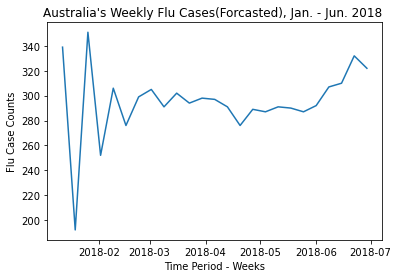

In [33]:
plt.plot(forcasted_days, forcasts)
plt.title("Australia's Weekly Flu Cases(Forcasted), Jan. - Jun. 2018 ")
plt.xlabel('Time Period - Weeks')
plt.ylabel('Flu Case Counts')

Text(0, 0.5, 'Flu Case Counts')

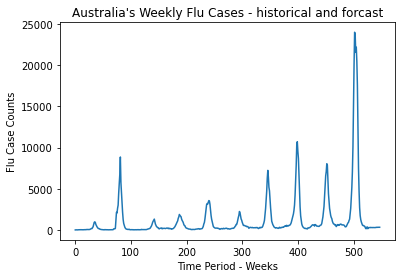

In [29]:
hist_plus_forcast = list(Weekly_Count_data1.Count) + list(forcast_as_df['Flu Cases - Weekly'])

plt.plot(hist_plus_forcast)
plt.title("Australia's Weekly Flu Cases - historical and forcast")
plt.xlabel('Time Period - Weeks')
plt.ylabel('Flu Case Counts')